**Ficheux et al, arXiv:2011.02634**

In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Ficheux et al(2020) "Fast logic with slow qubits:microwave-activated controlled-Z gate on low-frequency fuxoniums"

In [1]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import product, combinations
from IPython.display import display, Latex

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, HTML, Image

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$\hat{H} = \hat{H}^{(0)}_T + \hat{H}^{(0)}_F + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$

$$\hat{H}^{(0)}_F = 4 E_{C,F} \cdot \hat{n}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_T \cdot \hat{n}_F$$

$$\frac{\hat{H}_{drive}}{h} = \left( \varepsilon_T \hat{n}_T + \varepsilon_F \hat{n}_F \right) \cos(2\pi f_d t)$$

The energy levels should look like this :
<img src="energy_levels_03F_re-labeled.png" width="700">

# Individual qubits

## Tests to tune parameters (E_j and J_c)

In [ ]:
#Transmon
levels_t = 5
omega_t = 4.5 #6.0 
delta_t = -0.3

transm = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=levels_t)

#Fluxonium
levels_f = 7
ec_f = .973
el_f = .457
ej_f = 8
flux_f = 1/2 #pi in the cos

flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=100)
flx.diagonalize_basis(levels_f)

jc = 0.07
duo = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E{01} - E_{10}$$
$$\Delta = \left( E_{13} - E_{10} \right) -  \left( E_{03} - E_{00} \right)$$

The $\Delta$ is similar at the one in Ficheux but looking at the 0-3 transition of the Fluxonium

In [ ]:
def zeta_zz(omega_t, delta_t, levels_t, ec_f, el_f, ej_f, flux_f, levels_f, jc):
    transm = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=levels_t)
    flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=100)
    flx.diagonalize_basis(levels_f)

    energies_t, eig_states_t = transm.eig_states(levels_t)
    energies_f, eig_states_f = flx.eig_states(levels_f)
    
    duo = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_sys, eigstates_sys = duo.eig_states() 
    
    
    duo_bare = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
    energies_bare, eigstates_bare = duo_bare.eig_states() 

    energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
    count = 0
    for k in range(0, levels_t):
        for m in range(0, levels_f):
            energies_in_lexico[count] = energies_t[k] + energies_f[m]
            count += 1
    ascending_to_lexico = np.argsort(energies_in_lexico)
    label_converter = ascending_to_lexico
    
    def label_to_energies(
        k: int, 
        m: int,
        levels_f: int,
        energies: np.ndarray,  #in ascending order
        label_converter: np.ndarray 
    ) -> float:
        label = k*levels_f + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
        index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
        return energies[index]
    

    return label_to_energies(1, 1, levels_f, energies_sys, label_converter) + \
           label_to_energies(0, 0, levels_f, energies_sys, label_converter) - \
           label_to_energies(0, 1, levels_f, energies_sys, label_converter) - \
           label_to_energies(1, 0, levels_f, energies_sys, label_converter)
    
    
def delta_btw_10_13_n_00_03(omega_t, delta_t, levels_t, ec_f, el_f, ej_f, flux_f, levels_f, jc):
    transm = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=levels_t)
    flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=100)
    flx.diagonalize_basis(levels_f)

    energies_t, eig_states_t = transm.eig_states(levels_t)
    energies_f, eig_states_f = flx.eig_states(levels_f)
    
    duo = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_sys, eigstates_sys = duo.eig_states() 
    
    
    duo_bare = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
    energies_bare, eigstates_bare = duo_bare.eig_states() 

    energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
    count = 0
    for k in range(0, levels_t):
        for m in range(0, levels_f):
            energies_in_lexico[count] = energies_t[k] + energies_f[m]
            count += 1
    ascending_to_lexico = np.argsort(energies_in_lexico)
    label_converter = ascending_to_lexico
    
    def label_to_energies(
        k: int, 
        m: int,
        levels_f: int,
        energies: np.ndarray,  #in ascending order
        label_converter: np.ndarray 
    ) -> float:
        label = k*levels_f + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
        index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
        return energies[index]
    

    return ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
             label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
           ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
             label_to_energies(0, 0, levels_f, energies_sys, label_converter) )

#     return np.abs(
#                     np.abs( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
#                              label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
#                     np.abs( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
#                              label_to_energies(0, 0, levels_f, energies_sys, label_converter) )
#                     )

In [ ]:
print("With this set of parameters, the crosstalk is zeta_zz =", 1000*zeta_zz(omega_t, delta_t, levels_t, ec_f, el_f, ej_f, flux_f, levels_f, jc), "MHz")
print("And the Delta is Delta =" , 1000*delta_btw_10_13_n_00_03(omega_t, delta_t, levels_t, ec_f, el_f, ej_f, flux_f, levels_f, jc), "MHz")

In [ ]:
N = 500
jc = .07

rg_ej_f = np.linspace(4, 10, N)
plt.figure(figsize = (12, 6))

zz = np.array([zeta_zz(omega_t, delta_t, levels_t, ec_f, el_f, rg_ej_f[i], flux_f, levels_f, jc) for i in range(N)])
Delta = np.array([delta_btw_10_13_n_00_03(omega_t, delta_t, levels_t, ec_f, el_f, rg_ej_f[i], flux_f, levels_f, jc) for i in range(N)])
                 
plt.plot(rg_ej_f, 1000 *np.abs(zz), label = '$\zeta_{ZZ}$')
plt.plot(rg_ej_f, 1000* np.abs(Delta) , label = "$\Delta$")

plt.plot([ej_f, ej_f], [1000*min(np.min(Delta), np.min(zz)), 1000*max(np.max(Delta), np.max(zz))], linestyle = ":", label = "target $E_J$")

plt.xlabel("$E_J$")
plt.ylabel("$\mathrm{MHz}$")

plt.yscale('log')

plt.title("For E_j =" + str(ej_f))
plt.legend()

In [ ]:
N = 100
ej_f = 8

rg_jc = np.linspace(0.001, 0.25, N)
plt.figure(figsize = (12, 6))

zz = np.array([zeta_zz(omega_t, delta_t, levels_t, ec_f, el_f, ej_f, flux_f, levels_f, rg_jc[i]) for i in range(N)])
Delta = np.array([delta_btw_10_13_n_00_03(omega_t, delta_t, levels_t, ec_f, el_f, ej_f, flux_f, levels_f, rg_jc[i]) for i in range(N)])
                 
plt.plot(rg_jc, 1000 * np.abs(zz), label = '$\zeta_{ZZ}$')
plt.plot(rg_jc, 1000 * np.abs(Delta) , label = "$\Delta$")

plt.plot([jc, jc], [1000*min(np.min(Delta), np.min(zz)), 1000*max(np.max(Delta), np.max(zz))], linestyle = ":", label = "target $J_c$")

plt.xlabel("$J_c$")
plt.ylabel("$\mathrm{MHz}$")

plt.yscale('log')
plt.title("For E_j =" + str(ej_f))

plt.legend()

In [ ]:
def n_0_1_f(ec_f, el_f, ej_f, flux_f, levels_f):
    flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=100)
    flx.diagonalize_basis(levels_f)
    
    energies_f, eig_states_f = flx.eig_states(levels_f)
    
    n_op = flx.charge_op(as_qobj = True)
    eig_0 = qtp.Qobj(eig_states_f[0])
    eig_1 = qtp.Qobj(eig_states_f[1])
    
    return np.abs( ( eig_1.dag() * n_op * eig_0 ).full()[0, 0])


N = 100

rg_ej_f = np.linspace(4, 10, N)
n01 = np.array([n_0_1_f(ec_f, el_f, rg_ej_f[k], flux_f, levels_f) for k in range(N)])

plt.figure(figsize = (12, 6))
plt.plot(rg_ej_f, n01)
plt.plot([ej_f, ej_f], [np.min(n01),np.max(n01)], linestyle = ":", label = "target $E_J$")

plt.ylabel("$\hat{n}^F_{0-1}$")
plt.xlabel("$E_J$")

plt.legend()

## Transmon init

In [ ]:
# Values in GHz (divided by h)
#Transmon (t)
# ec_t = .973
# ej_t = 5.899 
# flux_t = 1/2  #pi in the cos

# charge_offset_t = 0 #?

# n_fock = 100

# levels_t = levels
# transm = pysqkit.qubits.Transmon(label = 'T',
#                                  charge_energy = ec_t, 
#                                  joseph_energy = ej_t, 
#                                  ext_flux = flux_t, 
#                                  charge_offset = charge_offset_t,
#                                  dim_hilbert=n_fock)


omega_t = 4.5 #6.0 
delta_t = -0.3
levels_t = 5

transm = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=levels_t)
# transm.diagonalize_basis(levels)

In [ ]:
energies_t, eig_states_t = transm.eig_states(levels_t)
for k in range(0, 4):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^T = ' + str(energies_t[k + 1] - energies_t[k]) + ' GHz' )
print('------')

In [ ]:
#plot les nvx d'énergie des a et b ide by side

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab_t = ["$| " + str(k) + " \\rangle $" for k in range(levels_t)]

def plot_energies_single(energies, text_lab_qbt, levels_qbt, opt, name):
    plt.figure(figsize=(5, 5))
    for k in range(0, levels_qbt):
        plt.plot([0,1], [energies[k]]*2, color='blue')
        plt.text(-0.1, energies[k], text_lab_qbt[k], fontsize=opt['fs_text'], color='blue')

    plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    plt.title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    im = plt.gca()
    im.xaxis.set_visible(False)
    plt.xlim(-.1, 1)
    

plot_energies_single(energies_t, text_lab_t, levels_t, opt, "transm")


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities;

In [ ]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^T| = ' + \
          str(np.abs(get_mat_elem(transm.charge_op(), eig_states_t[k], eig_states_t[k + 1]))))

print('------')
print('|n_' + str(0) + str(3) + '^T| = '  + \
      str(np.abs(get_mat_elem(transm.charge_op(), eig_states_t[0], eig_states_t[3]))))


In [ ]:
def plot_charge_op(qbt, name, levels_qbt):
    lv = range(levels_qbt)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = qbt.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    plt.figure(figsize = (5, 5))
    
    plt.imshow(np.abs(mat_elements), cmap='viridis')

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        plt.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    im = plt.gca()
    im.set_xticks(lv)
    im.set_yticks(lv)
    im.set_xticklabels(level_labels, fontsize = 14)
    im.set_yticklabels(level_labels, fontsize = 14)

    plt.colorbar()

    plt.title(name +  ' matrix elements')

plot_charge_op(transm, "transm", levels_t)

## Fluxonium init

In [ ]:
# Values in GHz (divided by h)
#Fluxonium (F)
ec_f = .973
el_f = .457
ej_f = 8
flux_f = 1/2 #pi in the cos

levels_f = 7
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=100)
flx.diagonalize_basis(levels_f)


In [ ]:
energies_f, eig_states_f = flx.eig_states(levels_f)
for k in range(0, 5):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^F = ' + str(energies_f[k + 1] - energies_f[k]) + ' GHz' )
print('------')

In [ ]:
text_lab_f = ["$| " + str(k) + " \\rangle $" for k in range(levels_f)]

plot_energies_single(energies_f, text_lab_f, levels_f, opt, "flx")

In [ ]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^F| = ' + \
          str(np.abs(get_mat_elem(flx.charge_op(), eig_states_f[k], eig_states_f[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^F| = '  + \
      str(np.abs(get_mat_elem(flx.charge_op(), eig_states_f[0], eig_states_f[3]))))

In [ ]:
plot_charge_op(flx, "flx", levels_f)

## Comparison and unification (T-F convention)

In [ ]:
#plot les nvx d'énergie des a et b ide by side

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_single(energies, text_lab_qbt, levels_qbt, opt, name, ax):
    for k in range(0, levels_qbt):
        ax.plot([0,1], [energies[k]]*2, color='blue')
        ax.text(-0.1, energies[k], text_lab_qbt[k], fontsize=opt['fs_text'], color='blue')

    ax.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    ax.xaxis.set_visible(False)
    ax.set_xlim(-.1, 1)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_energies_single(energies_t, text_lab_t, levels_t, opt, "'transm'",  ax[0])
plot_energies_single(energies_f, text_lab_f, levels_f, opt, "'flx'",  ax[1])


In [ ]:
def plot_charge_op(qbt, name, levels_qbt, ax, vmin, vmax):
    lv = range(levels_qbt)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = qbt.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)


    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(transm.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(transm.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ima = plot_charge_op(transm, "'transm'", levels_t, ax[0], vmin, vmax)
imb = plot_charge_op(flx, "'flx'", levels_f, ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

In [ ]:
energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        energies_in_lexico[count] = energies_t[k] + energies_f[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

If $ \textit{ascending_to_lexico}[i] = j$ Then  $$i^{th}\mathrm{\ in \ ascending \ energies \ order \ is \ } j^{th} \mathrm{\ in \ lexicographic \ order}$$

In [ ]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels_f: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels_f: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

In [ ]:
def energy_ascending_order_to_label(
    k : int,
    levels_f: int,
    label_converter : np.ndarray):
    
    lexico_rank = label_converter[k]
    i = lexico_rank//levels_f
    j = lexico_rank%levels_f
    
    return i, j
    

# Coupled qubits

We'll take coupling strength of $J_c = 70 \mathrm{MHz}$

## Role of J_c

In [ ]:
n_points = 20

levels_plot = 12
labels_to_plot = [energy_ascending_order_to_label(k, levels_f, label_converter) for  k in range(levels_plot)]

# interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3], [0,4]]
# labels_to_plot = interest_levels


jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_f*levels_t, n_points], dtype=float)
for k in range(0, n_points):
    coupled_qbts = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_qbts.eig_energies(levels_f*levels_t)
    
print("We'll plot the following levels :  ")
if 'levels_plot' in locals():
    print("(the " + str(levels_plot)+" first in term of energy)")
for tpl in labels_to_plot:
    print(tpl)

In [ ]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    labels_to_plot,
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    fig, ax = plt.subplots(figsize=(7, 7))
    for k, m in labels_to_plot:
        plt.plot(jc_list, [label_to_energies(k, m, levels_f, en_mat[:, ii], label_converter) for ii in range(len(jc_list))], 
             linewidth=opt['lw'], color='black')
        plt.text(-0.03, label_to_energies(k, m, levels_f, en_mat[:, 0], label_converter), 
                 "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')
        
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])

    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, labels_to_plot, plot_setup) 

## Coupling

In [ ]:
jc = .07 #GHz (divided by h)

coupled_qbts = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_qbts.eig_states() 

coupled_qbts_bare = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_qbts_bare.eig_states() 


for k in range(len(labels_to_plot)):
    i, j = labels_to_plot[k]
    print(str(k)+"th energy level |" + str((i, j)) + 
                  "> :  Bare : " + str(np.round(label_to_energies(i, j, levels_f, energies_bare, label_converter), 4)) + 
                  "[GHz] || Interacting : " + str(np.round(label_to_energies(i, j, levels_f, energies_sys, label_converter), 6)) + "[GHz]")

In [ ]:
# def plot_charge_op(opé, levels_f, name, xmax, ymax):
#     lvx = range(xmax)
#     lvy = range(ymax)
#     level_labels = ['$ |' + str(  np.argmax(np.abs(level))//levels_f  ) + \
#                                 str(  np.argmax(np.abs(level)) %levels_f  ) + '\\rangle $' for level in eigstates_sys]
#     mat_elements = np.zeros((xmax, ymax))
    
    
#     plt.figure(figsize = (7, 7))
#     for a in range(xmax):
#         for b in range(ymax):
#             in_level = np.conj(eigstates_sys[a].T)
#             out_level = eigstates_sys[b]
#             mat_elements[a, b] = np.abs(in_level.dot(opé).dot(out_level))
# #             plt.text(a, b, '{:.2f}'.format(float(mat_elements[a, b])), ha="center", va="center", color="white")


#     plt.imshow(np.abs(mat_elements), cmap='viridis')            

#     plt.xticks(ticks = lvx, labels = level_labels[:xmax], fontsize = 14)
#     plt.yticks(ticks = lvy, labels = level_labels[:ymax], fontsize = 14)

#     plt.title(name +  ' matrix elements')
#     plt.colorbar()
    
#     return mat_elements

# n_t = tensor_prod([transm.charge_op(), np.identity(levels_f)])
# n_f = tensor_prod([np.identity(levels_t), flx.charge_op()])
# ope = n_t*n_f

# _ = plot_charge_op(ope, levels_f, "$\hat{n}_T \hat{n}_F$",30, 30)

## Energies and eigenvalues of H

In [ ]:
#Compare levels bare-int

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

plt.figure(figsize=(7, 7))
for ii in range(len(labels_to_plot)):
    
    k, m = labels_to_plot[ii]
    
    plt.plot([0,.999], [label_to_energies(k, m, levels_f, energies_bare, label_converter)]*2, 
             color='blue', linestyle = ':', label = "bare")
    plt.text(-0.08, label_to_energies(k, m, levels_f, energies_bare, label_converter), 
             "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='blue')

    plt.plot([1.001, 2], [label_to_energies(k, m, levels_f, energies_sys, label_converter)]*2, 
             color='black', label = "coupled")
    plt.text(+2.03,label_to_energies(k, m, levels_f, energies_sys, label_converter),
             "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')
    
    if ii == 0:
        plt.legend()
    
plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
plt.tick_params(axis='both', labelsize=opt['ls'])

frame1 = plt.gca()
frame1.axes.xaxis.set_visible(False)



# Drive

In [ ]:
eig_states_by_label = []

for i_t in range(levels_t):
    eig_states_by_label.append([])
    for i_f in range(levels_f):
        eig_states_by_label[i_t].append(qtp.Qobj(inpt=  label_to_states(i_t, i_f, levels_f, eigstates_sys, label_converter), 
                   dims=[[levels_t, levels_f], [1, 1]], shape=[levels_f*levels_t, 1]))

In [ ]:
n_t = qtp.tensor(transm.charge_op(as_qobj = True), qtp.qeye(flx.charge_op(as_qobj = True).dims[0]))
n_f = qtp.tensor(qtp.qeye(transm.charge_op(as_qobj = True).dims[0]), flx.charge_op(as_qobj = True))
n_charge = [n_t, n_f]

## calculations of parameters (eta, freq...) (TBD)

In [ ]:
big_delta = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
            ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(0, 0, levels_f, energies_sys, label_converter) )
print("Big Delta is :", big_delta*1000, "MHz")

For this case we look at the 10-13 and 00-03 transitions so we process the corresponding Rabi frequencies :

$$\Omega_{10-13}  = \left| \epsilon_T \langle 10 | \hat{n}_T | 13 \rangle + \epsilon_F \langle 10 | \hat{n}_F | 13 \rangle \right|$$
$$\Omega_{00-03}  = \left| \epsilon_T \langle 00 | \hat{n}_T | 03 \rangle + \epsilon_F \langle 00 | \hat{n}_F | 03 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{10-13}}{\Omega_{00-03}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{10-13} - f_{00-03}$$
$$\delta = f_{10-13} - f_d$$

These conventions are taken in orde to have : $\Omega = \sqrt{\Omega_{10-13}^2  + \delta^2} = \sqrt{\Omega_{00-03}^2  + (\delta - \Delta)^2}$

The $\Delta$ is fixed by the parameters of the qubits, we now need to settle the values for the drive parameters.

First we need to fix the $\varepsilon$.

We take the condition of the paper :
$$\Omega = \Delta$$

However, one equation for two parameters is not enough... We assume that the fluxonium is driven much more than the transmon (as we are mainly looking at the 0-3 transtion of F). For example, we take $\dfrac{\varepsilon_T}{\varepsilon_F} = .1$
Now we have enough constraints to find values for every parameters.


With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

### best eta_f

#### Functions

In [ ]:
def Omega1(eta_f, eta_t_over_eta_f):
    eta_t = eta_f * eta_t_over_eta_f
    eta = [eta_t, eta_f]
    
    rabi_10_13 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )
    rabi_00_03 = np.abs(eta[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )
    rabi_ratio = rabi_10_13/rabi_00_03
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1) 
    
    big_delta = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
            ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(0, 0, levels_f, energies_sys, label_converter) )
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_10_13**2 + small_delta**2)

def Omega2(eta_f, eta_t_over_eta_f):
    eta_t = eta_f * eta_t_over_eta_f
    eta = [eta_t, eta_f]
    
    rabi_10_13 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )
    rabi_00_03 = np.abs(eta[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )
    rabi_ratio = rabi_10_13/rabi_00_03
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1) 
    
    
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_00_03**2 + (small_delta - big_delta)**2)

In [ ]:
def find_null(fct, mini, maxi, threshold = 1e-8):
    if maxi - mini < threshold:
        return .5 *(mini+maxi)
    else:
        if fct(mini) <= fct(maxi):#non decreasing
            mid = .5 * (mini+maxi)
            if fct(mid)<0:
                return find_null(fct, mid, maxi, threshold)
            elif fct(mid)>0:
                return find_null(fct, mini, mid, threshold) 
            else:
                return mid
            
        else: #decreasing
            def op_fct(x):
                return -fct(x)
            return find_null(op_fct, mini, maxi, threshold)
        
def is_suitable(fct, mini, maxi, step):
    if np.sign(fct(mini)) == np.sign(fct(maxi)): #check that crosses 0
        return False
    
    increasing = fct(mini) < fct(maxi)
    for arg in np.arange(mini, maxi, step): #check monotony
        if (fct(arg) < fct(arg + step) ) != increasing:
            return False
    
    return True
        
def eta_f_of_ratio(eta_t_over_eta_f, threshold_res = 1e-8, threshold_check = 1e-3):
    big_delta = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
            ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(0, 0, levels_f, energies_sys, label_converter) )
    
    def O1_min_O2(e_f):
        return Omega1(e_f, eta_t_over_eta_f) - Omega2(e_f, eta_t_over_eta_f)
    
    def O2_min_Delta(e_f):
        return Omega2(e_f, eta_t_over_eta_f) - big_delta
    
    def Delta_min_O1(e_f):
        return  big_delta - Omega1(e_f, eta_t_over_eta_f)

    
    if is_suitable(O1_min_O2, threshold_res, 1, threshold_check) \
        and is_suitable(O2_min_Delta, threshold_res, 1, threshold_check) \
        and is_suitable(Delta_min_O1, threshold_res, 1, threshold_check):
            
            return 1/3 * ( find_null(O1_min_O2, threshold_res, 1, threshold_res)  \
                            + find_null(O2_min_Delta, threshold_res, 1, threshold_res)  \
                            + find_null(Delta_min_O1, threshold_res, 1, threshold_res)   \
                          )
    else :
        print("Not all functions are suitable : \nO1_min_O2", is_suitable(O1_min_O2, threshold_res, 1, threshold_check),
        "\nO2_min_Delta", is_suitable(O2_min_Delta, threshold_res, 1, threshold_check),
        "\nDelta_min_O1", is_suitable(Delta_min_O1, threshold_res, 1, threshold_check))
        smpl_e_f = np.linspace(0, 1, 1000)
        plt.figure()
        plt.plot(smpl_e_f, O1_min_O2(smpl_e_f), label = 'O1_min_O2')
        plt.plot(smpl_e_f, O2_min_Delta(smpl_e_f), label = 'O2_min_Delta')
        plt.plot(smpl_e_f, Delta_min_O1(smpl_e_f), label = 'Delta_min_O1')
        plt.legend()
        
        return None

#### Auto (over the top)

In [ ]:
#automated
eta_t_over_eta_f_test = 0

deb = time.time()
print("For a ratio of ", eta_t_over_eta_f_test, "the best eta_f is :", 
      eta_f_of_ratio(eta_t_over_eta_f_test, threshold_res = 1e-15, threshold_check = 1e-1))
print("It took ", time.time() - deb, "seconds")

In [ ]:
eta_f_opt = 0.03091755984900732

In [ ]:
rg_ratio = np.linspace(0, 1, 30)

deb = time.time()
rg_e_f = np.array( [eta_f_of_ratio(rg_ratio[ii], threshold_res = 1e-8, threshold_check = 1e-1) for ii in range(len(rg_ratio))] )
print("It took ", time.time() - deb, "seconds")

plt.figure()
plt.plot(rg_ratio, rg_e_f)
plt.xlabel("$\\varepsilon_T / \\varepsilon_F$")
plt.ylabel("$\\varepsilon_F$")

plt.title('$\mathrm{Optimal \ } \\varepsilon_F \mathrm{ \ as \ function \ of \ the \ ratio \ } \\varepsilon_T / \\varepsilon_F$')

#### Manual

In [ ]:
#manually
eta_t_over_eta_f_test = .1
rg_e_f = np.linspace(0.0001, 1, 10000)

plt.figure()
plt.plot(rg_e_f, Omega1(rg_e_f, eta_t_over_eta_f_test), color = 'blue', label = 'O1')
plt.plot(rg_e_f, Omega2(rg_e_f, eta_t_over_eta_f_test), color = 'red', label = 'O2')
plt.plot(rg_e_f, [big_delta]*len(rg_e_f), color = 'orange', label = 'big Delta')

plt.xlabel("$\\varepsilon_F$")
plt.xlim([.0308609, .0308643])
plt.ylim([0.022762, 0.022765])
plt.legend()

### Rest of the parameters :

In [ ]:
ratio_e = eta_t_over_eta_f_test
eta_f = eta_f_opt #ex-eta_b

# eta_f = 0.030862 #ex-eta_b
# ratio_e = .1

eta_t = ratio_e * eta_f
eta = [eta_t, eta_f]

rabi_10_13 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )

rabi_00_03 = np.abs(eta[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )

rabi_ratio = rabi_10_13/rabi_00_03
print("The rabi frequencies are : Omega_10_13 =", rabi_10_13, "GHz  ; Omega_00_03 =", rabi_00_03, 
      "GHz \nSo we have : r =", rabi_ratio)

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
print("\ndelta/Delta =", ratio_delta)

In [ ]:
small_delta = big_delta * ratio_delta

freq_drive = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
               label_to_energies(1, 0, levels_f, energies_sys, label_converter) )  - small_delta

t_drive = 1/big_delta

print("Big Delta = ", big_delta)
print("small delta = ", small_delta)

print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')

In [ ]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')

#  Simulations

## Simu

In [ ]:
#simulation setup (noiseless)
pts_per_drive_period = 15
simu_time = rabi_period

nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
tlist = np.linspace(0, simu_time, nb_points)*2*np.pi

state_in = eig_states_by_label[0][1] #+ eig_states_by_label[0][1] + eig_states_by_label[1][0] + eig_states_by_label[1][1]
rho_in = state_in*state_in.dag()

hamil0 = coupled_qbts.hamiltonian(as_qobj=True)
hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 

pulse_drive = np.cos(freq_drive*tlist)

In [ ]:
# Simulation run
result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

In [ ]:
#for the following analysis , we'll look at the following states:

# levels_plot = 35
# interest_levels = [energy_ascending_order_to_label(ii, levels_f, label_converter) for ii in range(levels_plot)]

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0, 3], [1, 3], [0, 4]]

labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

fig_size_each = (3,3)
figsize = (fig_size_each[0]*4), (fig_size_each[1]*int(np.ceil(len(labels)/4)))

## Probs

In [ ]:
#the rhos
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j] * eig_states_by_label[i][j].dag())                       

#probas :
probs = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, nb_points):
    for r in range(len(labels)):
        i, j = interest_levels[r]
        probs[r, k] = qtp.expect(rhos_by_label[i][j], result.states[k]) 

In [ ]:
#plots :

def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist/(2*np.pi), probs[k, :])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k])

        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                 each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                 $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    return 

plot_probas(tlist, probs)

## Phases

In [ ]:
#phases :
phases = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, nb_points):
     for r in range(len(labels)):
        i, j = interest_levels[r]
        phases[r, k] = (cmath.phase((result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0]) - \
                    ((label_to_energies(i, j, levels_f, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        
phases = phases%(np.pi*2) - np.pi

In [ ]:
def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :]/np.pi)
        ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)/\pi$")
        ax[k//4, k%4].set_ylim([-1, 1])
plot_phases(tlist, phases)    

## Projections

In [ ]:
#projections
proj = np.zeros([len(labels), nb_points], dtype=float)*1j
for k in range(0, nb_points):
     for r in range(len(labels)):
        i, j = interest_levels[r]
        proj[r, k] = (result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0] \
            / np.exp(1j*((label_to_energies(i, j, levels_f, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))

In [ ]:
def plot_proj(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    plot_type = None
) -> None:

    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        if (plot_type is None) or plot_type == "all":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

        elif plot_type == "real":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            
        elif plot_type == "imag":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')

        elif plot_type == "abs":
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

        elif plot_type == "real&imag":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            
        else:
            print("Value of plot_type should be 'None' ; 'real' ; 'imag' ; 'abs' ; 'real&imag' OR 'all'")
            
        ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k])

        ax[k//4, k%4].set_ylim([-1,1])
        ax[k//4, k%4].legend()

        if k%4 != 0:
                ax[k//4, k%4].axes.yaxis.set_ticklabels([])

plot_proj(tlist, proj, plot_type = 'all')

# Automatised test

## Init qubits

In [2]:
#init qubits :
omega_t = 4.5 #6.0 
delta_t = -0.3
levels_t = 5

transm = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=levels_t)
energies_t, eig_states_t = transm.eig_states(levels_t)
text_lab_t = ["$| " + str(k) + " \\rangle $" for k in range(levels_t)]

In [3]:
ec_f = .973
el_f = .457
ej_f = 8
flux_f = 1/2 #pi in the cos

levels_f = 8
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=100)
flx.diagonalize_basis(levels_f)
energies_f, eig_states_f = flx.eig_states(levels_f)
text_lab_f = ["$| " + str(k) + " \\rangle $" for k in range(levels_f)]

<IPython.core.display.Javascript object>


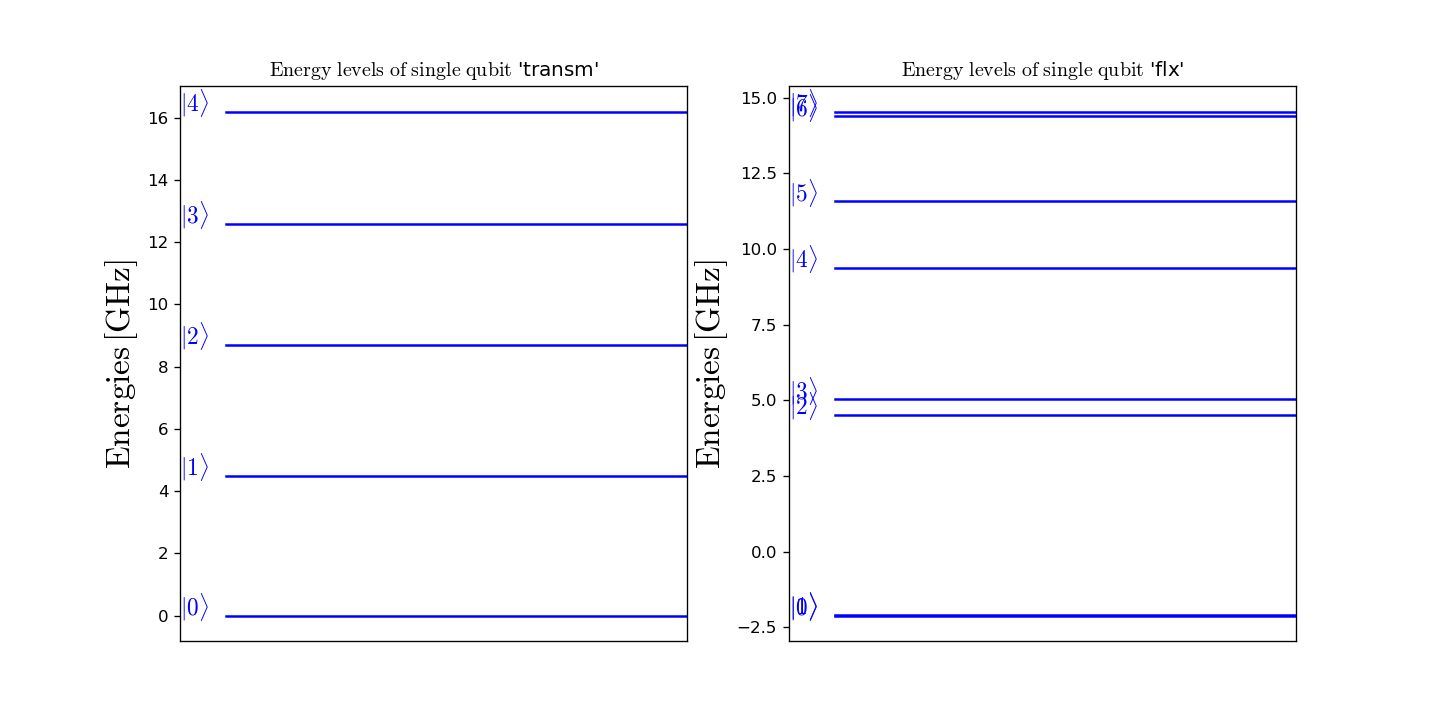

In [4]:
opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_single(energies, text_lab_qbt, levels_qbt, opt, name, ax):
    for k in range(0, levels_qbt):
        ax.plot([0,1], [energies[k]]*2, color='blue')
        ax.text(-0.1, energies[k], text_lab_qbt[k], fontsize=opt['fs_text'], color='blue')

    ax.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    ax.xaxis.set_visible(False)
    ax.set_xlim(-.1, 1)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_energies_single(energies_t, text_lab_t, levels_t, opt, "'transm'",  ax[0])
plot_energies_single(energies_f, text_lab_f, levels_f, opt, "'flx'",  ax[1])


<IPython.core.display.Javascript object>


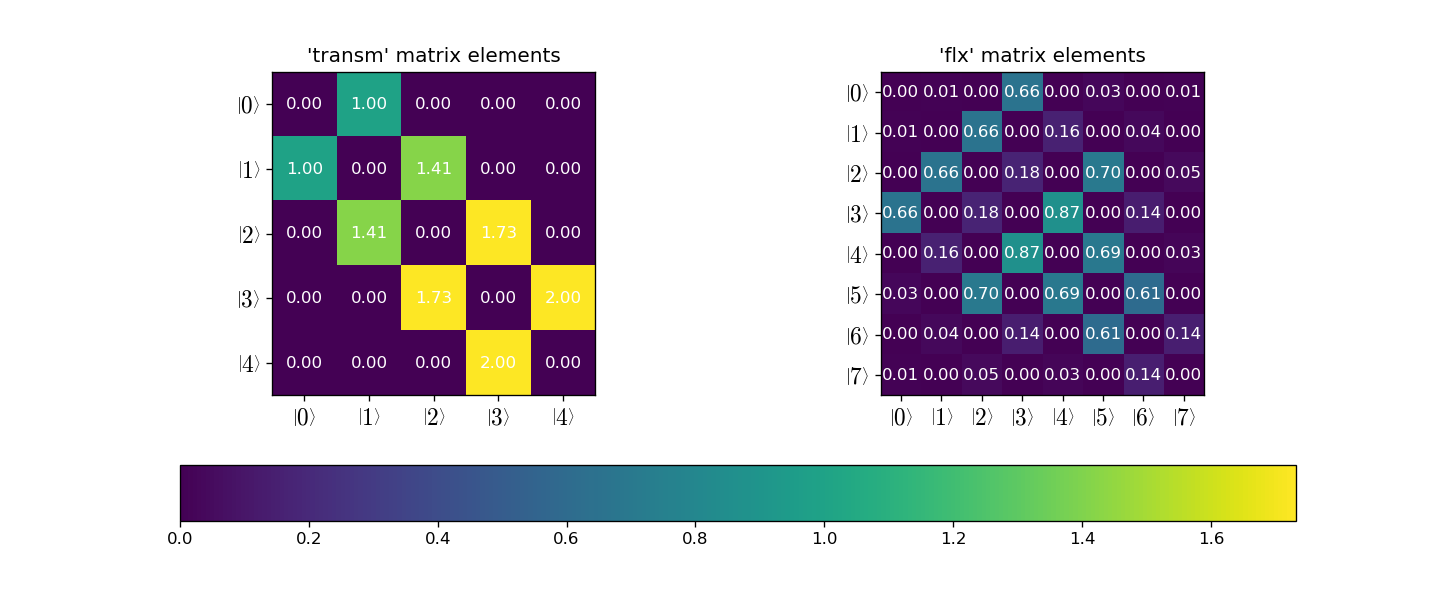

In [5]:
def plot_charge_op(qbt, name, levels_qbt, ax, vmin, vmax):
    lv = range(levels_qbt)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = qbt.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)


    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(transm.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(transm.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ima = plot_charge_op(transm, "'transm'", levels_t, ax[0], vmin, vmax)
imb = plot_charge_op(flx, "'flx'", levels_f, ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

## function body

In [6]:
def test_simu(transm, levels_t, flx, levels_f, jc, eta, list_init, freq_drive = None, freq_drive_trans = None,
              pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
              plot_spectrum = True, levels_plot = 12, interest_levels = None,
             plot_proba = True, plot_phase = False, plot_proj = False, mute = False,
             figsize_each = (3,3) ):
    
    
    energies_t, eig_states_t = transm.eig_states(levels_t)
    energies_f, eig_states_f = flx.eig_states(levels_f)
    
    #we build functions to link labels and energies
    energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
    count = 0
    for k in range(0, levels_t):
        for m in range(0, levels_f):
            energies_in_lexico[count] = energies_t[k] + energies_f[m]
            count += 1
    ascending_to_lexico = np.argsort(energies_in_lexico)
    label_converter = ascending_to_lexico
    
    # This function allows to return the energy of the "adiabatically continued" coupled levels
    def label_to_energies(
        k: int, 
        m: int,
        levels_f: int,
        energies: np.ndarray,  #in ascending order
        label_converter: np.ndarray 
    ) -> float:
        label = k*levels_f + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
        index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
        return energies[index]

    def label_to_states(
        k: int, 
        m: int,
        levels_f: int,
        eig_states: np.ndarray,
        label_converter: np.ndarray 
    ) -> float:
        label = k*levels_f + m
        index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
        return eig_states[index] 
    def energy_ascending_order_to_label(
        k : int,
        levels_f: int,
        label_converter : np.ndarray):

        lexico_rank = label_converter[k]
        i = lexico_rank//levels_f
        j = lexico_rank%levels_f

        return i, j
    
    
    
    
    #now we couple
    coupled_qbts = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_sys, eigstates_sys = coupled_qbts.eig_states() 
    
    coupled_qbts_bare = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
    energies_bare, eigstates_bare = coupled_qbts_bare.eig_states() 

    eig_states_by_label = []
    for i_t in range(levels_t):
        eig_states_by_label.append([])
        for i_f in range(levels_f):
            eig_states_by_label[i_t].append(qtp.Qobj(inpt=  label_to_states(i_t, i_f, levels_f, eigstates_sys, label_converter), 
                       dims=[[levels_t, levels_f], [1, 1]], shape=[levels_f*levels_t, 1]))
            
    eig_energies_by_label = []
    for i_t in range(levels_t):
        eig_energies_by_label.append([])
        for i_f in range(levels_f):
            eig_energies_by_label[i_t].append(label_to_energies(i_t, i_f, levels_f, energies_sys, label_converter))
                                            
                      
    
    if interest_levels is None:
        interest_levels = [energy_ascending_order_to_label(ii, levels_f, label_converter) for ii in range(levels_plot)]
    if not mute:
        print("The levels we will plot and analyze are the following :")
        print(interest_levels)
        
    if plot_spectrum:
        plt.figure(figsize=(7, 7))
        for k, m in interest_levels:
            plt.plot([0,.99], [label_to_energies(k, m, levels_f, energies_bare, label_converter)]*2, 
                     color='blue', linestyle = ':', label = "bare")
            plt.text(-0.08, label_to_energies(k, m, levels_f, energies_bare, label_converter), 
                     "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='blue')

            plt.plot([1.01, 2], [label_to_energies(k, m, levels_f, energies_sys, label_converter)]*2, 
                     color='black', label = "coupled")
            plt.text(+2.03,label_to_energies(k, m, levels_f, energies_sys, label_converter),
                     "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')

            if (k, m)==(0,0):
                plt.legend()

        plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])

        frame1 = plt.gca()
        frame1.axes.xaxis.set_visible(False)
        
    #construct drive parameters
    
    n_t = qtp.tensor(transm.charge_op(as_qobj = True), qtp.qeye(flx.charge_op(as_qobj = True).dims[0]))
    n_f = qtp.tensor(qtp.qeye(transm.charge_op(as_qobj = True).dims[0]), flx.charge_op(as_qobj = True))
    n_charge = [n_t, n_f]
    
    if not freq_drive_trans is None:#to target specific frequencies
        freq_drive = np.abs(label_to_energies(freq_drive_trans[1][0], freq_drive_trans[1][1], levels_f, energies_sys, label_converter) - \
                            label_to_energies(freq_drive_trans[0][0], freq_drive_trans[0][1], levels_f, energies_sys, label_converter) )
    elif freq_drive is None:
        
        rabi_10_13 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                            eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )

        rabi_00_03 = np.abs(eta[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                            eta[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )

        rabi_ratio = rabi_10_13/rabi_00_03
        ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
        
        big_delta = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
                      label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
                    ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
                      label_to_energies(0, 0, levels_f, energies_sys, label_converter) )
        small_delta = ratio_delta*big_delta

        freq_drive = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
                       label_to_energies(1, 0, levels_f, energies_sys, label_converter) )  - small_delta
        
        rabi_freq = big_delta
        rabi_period = 1/rabi_freq # [ns]
        
        t_drive = 1/big_delta
        
        if not mute:
            print("\n\nBig Delta is :", big_delta*1000, "MHz")
            print("\nThe rabi frequencies are : Omega_10_13 =", rabi_10_13, "GHz  ; Omega_00_03 =", rabi_00_03, 
                                              "GHz \nSo we have : r =", rabi_ratio)
            print("\ndelta/Delta =", ratio_delta)
            print("small delta = ", small_delta)

            print('\nRabi period: ' + str(rabi_period) + ' [ns]')
    
    if not('rabi_period' in locals() ):
         rabi_period = 0
            
    if not mute:    
        print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')
    
    if plateau_time is None:
        plateau_time =  rabi_period
    simu_time = plateau_time
        
    if not rise_time is None:
        simu_time+= 2*rise_time
    
    nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
    tlist = np.linspace(0, simu_time*2*np.pi, nb_points)

    #state init : if int is present in list then eigstate[int] is in sum
    state_init = sum([tpl[0] * eig_states_by_label[tpl[1]][tpl[2]] for tpl in list_init])
    
    hamil0 = coupled_qbts.hamiltonian(as_qobj=True)
    hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 
    
    if rise_time is None:
        pulse_drive = np.cos(freq_drive*tlist)
    else :
#         print("Custom drive")
        sigma = rise_time/(np.sqrt(2*np.pi))
        pulse_drive = np.zeros(len(tlist))
        for i in range(len(tlist)):
            t_i = tlist[i]/(2*np.pi)
            if t_i < rise_time:
                pulse_drive[i] = ( np.exp(-(t_i - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * np.cos(freq_drive*tlist[i])
            elif t_i < rise_time + plateau_time  :
                pulse_drive[i] = np.cos(freq_drive*tlist[i])
            else :
                pulse_drive[i] = ( np.exp(-(t_i - plateau_time - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * \
                                        np.cos(freq_drive*tlist[i])
    
    
    if with_drive :
        result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    else :
        result = solvkit.integrate(tlist, state_init, hamil0, [], [], [], "mesolve")
        pulse_drive = np.zeros(len(tlist))
    
    
    
    #analysis:
    labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]
             
    #the rhos
    rhos_by_label = []
    for i in range(len(eig_states_by_label)):
        rhos_by_label.append([])
        for j in range(len(eig_states_by_label[0])):
            rhos_by_label[i].append(eig_states_by_label[i][j] * eig_states_by_label[i][j].dag())                       
       
    
    
    
    #probas :
    probs = np.zeros([len(labels), nb_points], dtype=float)
    for k in range(0, nb_points):
        for r in range(len(labels)):
            i, j = interest_levels[r]
            probs[r, k] = qtp.expect(rhos_by_label[i][j], result.states[k]) 
    
    #phases :
    phases = np.zeros([len(labels), nb_points], dtype=float)
    for k in range(0, nb_points):
         for r in range(len(labels)):
            i, j = interest_levels[r]
            phases[r, k] = (cmath.phase((result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0]) - \
                        ((label_to_energies(i, j, levels_f, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))
    phases = phases%(np.pi*2) - np.pi
    
    #projections
    proj = np.zeros([len(labels), nb_points], dtype=float)*1j
    for k in range(0, nb_points):
         for r in range(len(labels)):
            i, j = interest_levels[r]
            proj[r, k] = (result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0] \
                / np.exp(1j*((label_to_energies(i, j, levels_f, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        
    #plots :
    figsize = (figsize_each[0]*4), (figsize_each[1]*int(np.ceil(len(labels)/4)))
    
    if plot_proba:
        fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
        for k in range(0, len(labels)):
            ax[k//4, k%4].plot(tlist/(2*np.pi), probs[k, :])

            ax[k//4, k%4].set_ylim(0, 1.0)
            ax[k//4, k%4].set_title(labels[k])

            if k%4 != 0:
                ax[k//4, k%4].axes.yaxis.set_ticklabels([])
                
        fig = plt.gcf()
        fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                     each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                     $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
        
    if plot_phase:
        fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
        for k in range(0, len(labels)):
            ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :]/np.pi)
            ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)/\pi$")
            ax[k//4, k%4].set_ylim([-1, 1])
    
    if plot_proj:
        fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
        for k in range(0, len(labels)):
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k] +"$)$")
            
            ax[k//4, k%4].set_ylim([-1,1])
            ax[k//4, k%4].legend()
            
            if k%4 != 0:
                    ax[k//4, k%4].axes.yaxis.set_ticklabels([])
            
    dict_res = {}
    dict_res['probs'] = probs
    dict_res['phases'] = phases
    dict_res['proj'] = proj
    dict_res['eigstates_sys'] = eigstates_sys
    dict_res['energies_sys'] = energies_sys
    dict_res['tlist'] = tlist
    dict_res['labels'] = labels
    dict_res['rabi_period'] = rabi_period
    dict_res['pulse_drive'] = pulse_drive
    dict_res['hamil_drive'] = hamil_drive
    dict_res['freq_drive'] = freq_drive
    dict_res['eig_states_by_label'] = eig_states_by_label
    dict_res['eig_energies_by_label'] = eig_energies_by_label                                            
                                            
    
    return dict_res

## Small guide of the function `test_simu`

The arguments that this function can take are :

**Mandatory:**
    
1. The qubits and their levels : `transm` , `levels_t` , `flx` , `levels_f`  


2. parameters of the system (coupling and drive strengths) : `jc` , `eta`  
    
    
3. argument to set how you initialize the simulation : `list_init`
>*'list_init' is a list of triplets of form `[prefactor , state of 1st qubit , state of 2nd qubit]`*

<br>
  


**Optional:**
    
4. arguments to control the drive frequency : `freq_drive_trans` (default = None) , `freq_drive` (default = None)
>*if `freq_drive_trans` is **not None** then if should contain a list as such : `[[a,b], [c,d]]` and it'll take the frequency of the transition from $|ab\rangle$ to $|cd\rangle$ (in absolute value)*  
>*if `freq_drive_trans` is **None** AND `freq_drive` is **None** then we do the analysis via $\Delta$, $\delta$, $\Omega$... as in Ficheux*  
>*if `freq_drive_trans` is **None** AND `freq_drive` is **not None** then we take `freq_drive` and **don't do the analysis**.*

.

5. arguments to control the drive (pulse_drive) shape : `plateau_time` (default = None) , `rise_time` (default = None)  
>*if `plateau_time` is **None** then it is set to `rabi_period`*  
>*then we add `2x rise_time` to get the total simulation time and we implement the rise if `rise_time` is **not None**. (this way if both are **None**, we end up with `rabi_period`)*

.

6. arguments to control the resolution of the time list in the simulation : `pts_per_drive_period` (default = 15)  *(usually it's enough)*


7. arguments to remove the drive all-together : `with_drive` (default = True)


8. arguments to choose which levels are gonna be analyzed (ie whose proba, phase and projections are gonna be calculated and who are gonna be plotted) : `levels_plot` (default = 12) , `interest_levels` (default = None)
>*if `interest_levels` is **None** then we take the `levels_plot` first levels in term of energy, else we take the ones listed in `interest_levels` in the following form : `[[a,b], [c,d], [e,f]]` to have projections on $|ab\rangle$ ; $|cd\rangle$ and $|ef\rangle$ for example*

.

9. arguments to control what is displayed and how : `plot_spectrum` (default = False) , `plot_proba` (default = True) , `plot_phase` (default = True),  `plot_proj` (default = False) , `mute` (default = False) , `figsize_each` (default = (3, 3)) *(pretty self_explanatory)*

The function will return a dictionnary with the following entries :


- `energies_sys` the eigen energies in ascending order
- `eigstates_sys` the eigenstates orders by ascending energy
- `eig_states_by_label` the eigenstates stored in nested lists. `eig_states_by_label`[a][b] will return the quobj of the eigenvector closest to $|ab\rangle$
- `eig_energies_by_label` the eigenenergies stored in nested lists. `eig_energies_by_label`[a][b] will return the eigen energy of the eigenstate closest to $|ab\rangle$


- `rabi_period` 0 if no analysis has been done
- `pulse_drive` the one used in the simulation
- `hamil_drive` the one used in the simulation
- `freq_drive` the one used in the simulation


- `tlist` with the time array used for simulations (don't forget to divide by 2$\pi$)


- `labels` with the labels of all the interest_levels ready for lateX


- `probs` with the probabilities of being in each states specified (of not) in `interest_levels`  
- `phases` with the phases of the projections on each states specified (of not) in `interest_levels`   
- `proj` with the probabilities of being in each states specified (of not) in `interest_levels`  


## Tests with initialisation

<IPython.core.display.Latex object>

The levels we will plot and analyze are the following :
[[0, 0], [0, 1], [1, 0], [1, 1], [0, 3], [1, 3]]


Big Delta is : 22.762657403223585 MHz

The rabi frequencies are : Omega_10_13 = 0.01901418990099396 GHz  ; Omega_00_03 = 0.020324858636260493 GHz 
So we have : r = 0.9355140048586493

delta/Delta = 0.5497556752597749
small delta =  0.012513900091416095

Rabi period: 43.931601758342275 [ns]

Drive frequency fd: 7.155037104461214 [GHz]


<IPython.core.display.Javascript object>


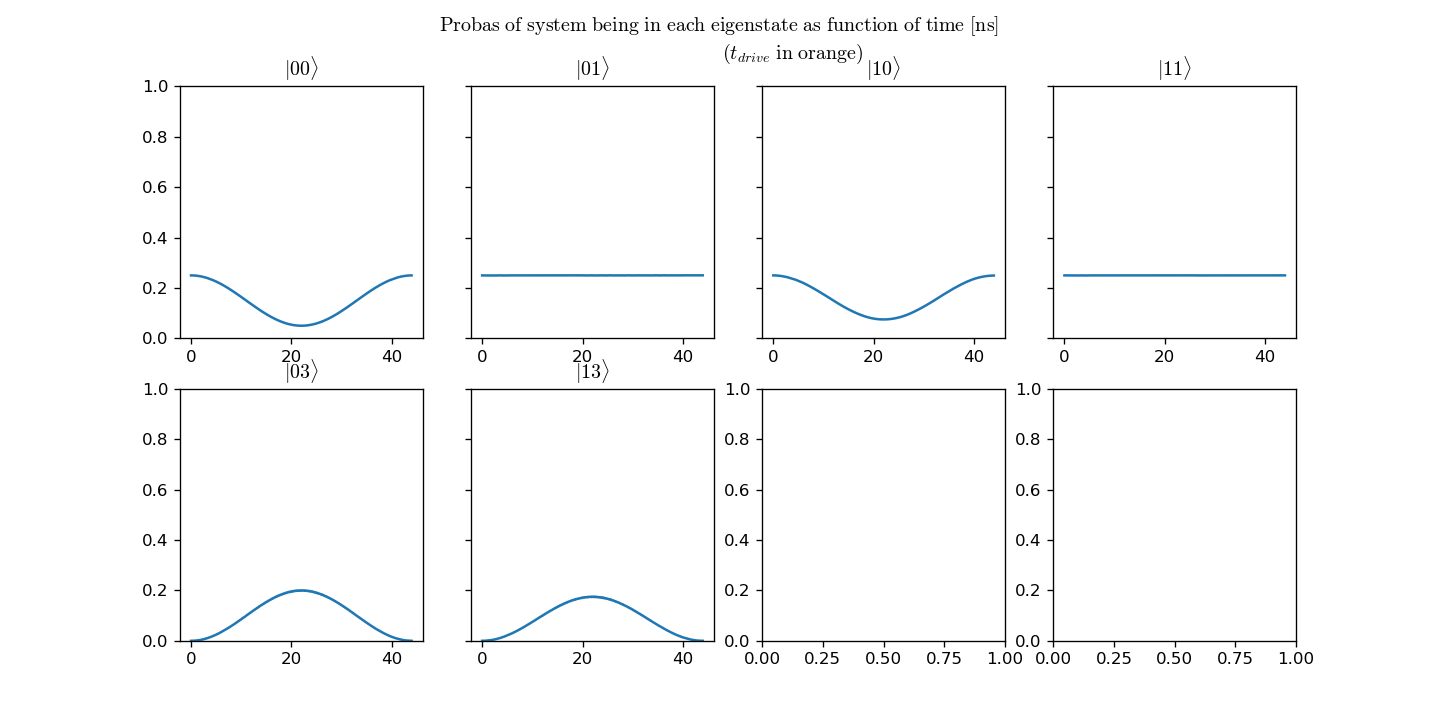

<IPython.core.display.Javascript object>


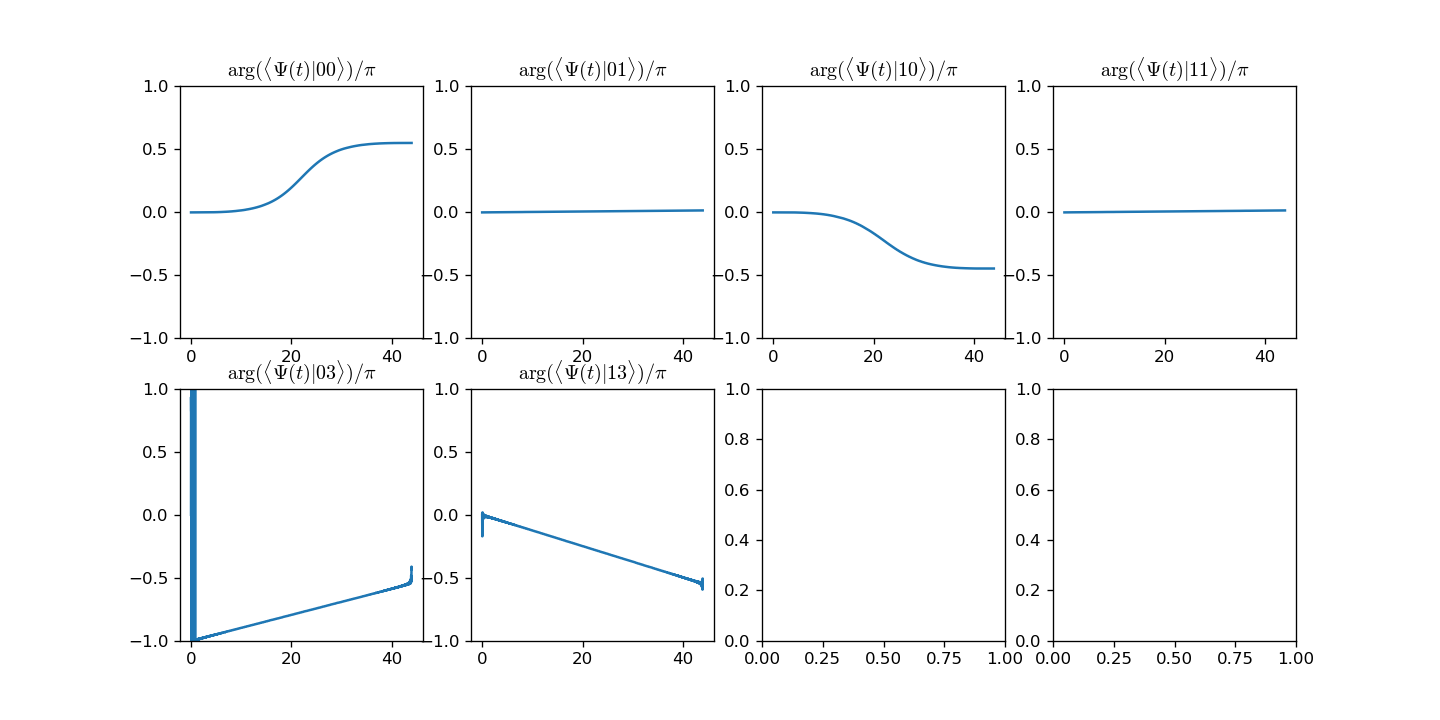

It took  9.02202582359314 seconds
The order in proj, probs, phases, ... is as follows :
['$| 00 \\rangle $', '$| 01 \\rangle $', '$| 10 \\rangle $', '$| 11 \\rangle $', '$| 03 \\rangle $', '$| 13 \\rangle $']


In [7]:
ratio_e_test = 0 #.1

# e_f_test = 0.030862  #best for ratio .1
e_f_test = 0.03091755984900732 #best for ratio 0

e_t_test = ratio_e_test * e_f_test
eta_test = [e_t_test, e_f_test]

jc_test = .07

display( Latex('the Epsilons are : $\\varepsilon_T $ = %.4f and $\\varepsilon_F $ = %.4f ' % (e_t_test, e_f_test)))


#list init contains tuples, the first argument is factor in the sum, second and third give state of flx_a and flx_b
list_init = [[1, 0, 0],  
             [1, 0, 1],
             [1, 1, 0],
             [1, 1, 1]]

deb = time.time()

#R) For 60ns -> 1000 points is good (maybe a little more)
dict_res = test_simu(transm = transm, 
                      levels_t = levels_t, 
                      flx = flx, 
                      levels_f = levels_f,
                      jc = jc_test, 
                      eta = eta_test,
                      list_init = list_init,
                      freq_drive = None,
                      freq_drive_trans = None,
                      plateau_time = None,
                      rise_time = None,
                      with_drive = True,
                      plot_spectrum = False,
                      levels_plot = None,
                      interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]],
                      plot_proba = True, 
                      plot_phase = True, 
                      plot_proj = False,
                      mute = False,
                      pts_per_drive_period = 15,
                      figsize_each = (3, 3))


print("It took ", time.time() - deb , "seconds")
#R) The order in phases, proj, probs... is as follows :
# 00 ; 01 ; 10 ; 11 ; 02 ; 12 : 20 : 21
print("The order in proj, probs, phases, ... is as follows :")
print(dict_res['labels'])

<IPython.core.display.Javascript object>


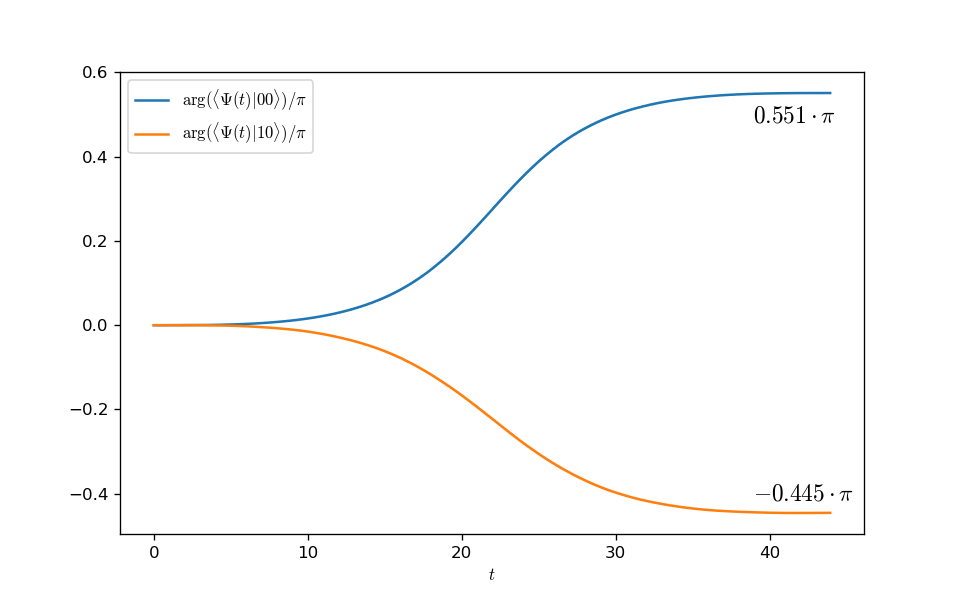

In [8]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['phases'][0]/np.pi, label = "$\mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][0] +"$)/\pi$")
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['phases'][2]/np.pi, label = "$\mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][2] +"$)/\pi$")

plt.text(dict_res['tlist'][-1]/(2*np.pi)-5, dict_res['phases'][0][-1]/np.pi - .07,
         "$"+str(np.round(dict_res['phases'][0][-1]/np.pi, 3)) + "\cdot\pi$",
         fontsize = 14)

plt.text(dict_res['tlist'][-1]/(2*np.pi)-5, dict_res['phases'][2][-1]/np.pi + .03,
         "$"+str(np.round(dict_res['phases'][2][-1]/np.pi, 3)) + "\cdot\pi$",
         fontsize = 14)

plt.xlabel("$t$")
plt.legend()

In [9]:
print("The drive_frequency is :", dict_res['freq_drive'], "GHz")
print("\nThe transition energy of 00 -> 03 is :", dict_res['eig_energies_by_label'][0][3] - dict_res['eig_energies_by_label'][0][0], "GHz")
print(  "The transition energy of 10 -> 13 is :", dict_res['eig_energies_by_label'][1][3] - dict_res['eig_energies_by_label'][1][0], "GHz")

The drive_frequency is : 7.155037104461214 GHz

The transition energy of 00 -> 03 is : 7.144788347149406 GHz
The transition energy of 10 -> 13 is : 7.16755100455263 GHz


In [ ]:
# plt.figure()
# plt.plot(dict_res['tlist']/(2*np.pi), dict_res['pulse_drive'])

#R) Weird shape could be liked to number of points too low (ie not enought points per period of the drive) 
#(the period of the drive is about .2 so there should be more than 50*(total time) points ie : for 60ns -> 3000pts at least)

<IPython.core.display.Javascript object>


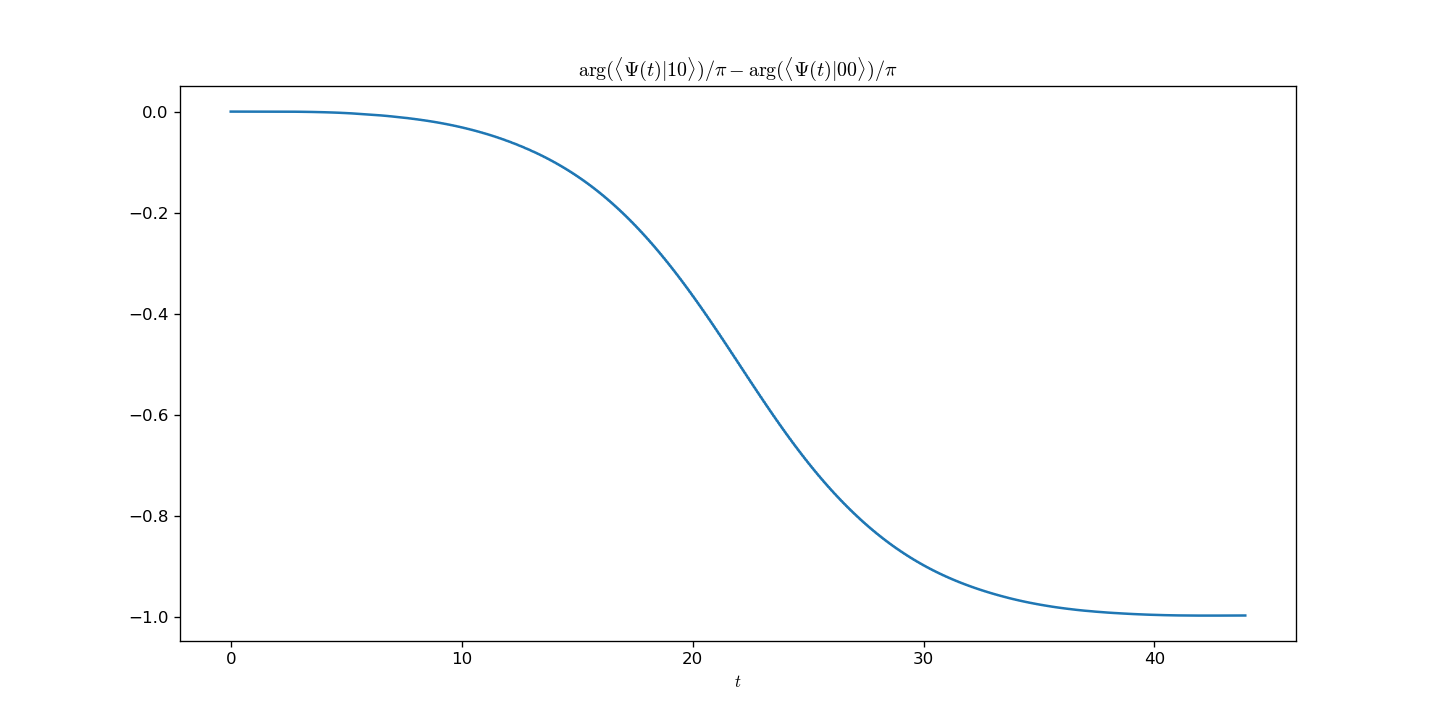

Final value of accumulated phase/pi :  -0.9964883053204886


In [10]:
plt.figure(figsize = (12, 6))

phase_acc = dict_res['phases'][2]/np.pi - dict_res['phases'][0]/np.pi 

plt.plot(dict_res['tlist']/(2*np.pi), phase_acc)

plt.title("$\mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][2] +"$)/\pi - \
            \mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][0] +"$)/\pi $") #- \
#             \mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][] +"$)/\pi - \
#             \mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][] +"$)/\pi - )
          
          
plt.xlabel('$t$')
print("Final value of accumulated phase/pi : ", phase_acc[-1])

### Test simple rabi for 12-13

In [ ]:
dict_res = test_simu(transm = transm, 
                      levels_t = levels_t, 
                      flx = flx, 
                      levels_f = levels_f,
                      jc = jc_test, 
                      eta = eta_test,
                      list_init = [[1, 1,2]], #list_init,
                      freq_drive = None,
                      freq_drive_trans = [[1, 2], [1, 3]],
                      plateau_time = 200,
                      rise_time = None,
                      with_drive = True,
                      plot_spectrum = False,
                      levels_plot = 12,
                      interest_levels = None, #[[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]],
                      plot_proba = True, 
                      plot_phase = False, 
                      plot_proj = False,
                      mute = False,
                      pts_per_drive_period = 15,
                      figsize_each = (3, 3))

expected = 1/np.abs((dict_res['eig_states_by_label'][1][2].dag() * dict_res['hamil_drive'] * dict_res['eig_states_by_label'][1][3]).full()[0,0])
print("We expect to find a Rabi period of : ", expected, "ns")

## Leakage

In [11]:
def leakage(transm, levels_t, flx, levels_f, jc, eta, list_init=  [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]], 
              freq_drive = None, freq_drive_trans = None,
              pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
              plot_spectrum = True, levels_plot = None, interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]],
              plot_proba = True, plot_phase = False, plot_proj = False, mute = False,
              figsize_each = (3,3) ):
    
    dict_res = test_simu(transm = transm, 
                              levels_t = levels_t, 
                              flx = flx, 
                              levels_f = levels_f,
                              jc = jc, 
                              eta = eta,
                              list_init = list_init,
                              freq_drive = freq_drive,
                              freq_drive_trans = freq_drive_trans,
                              plateau_time = plateau_time,
                              rise_time = rise_time,
                              with_drive = with_drive,
                              plot_spectrum = plot_spectrum,
                              levels_plot = levels_plot,
                              interest_levels = interest_levels,
                              plot_proba = plot_proba, 
                              plot_phase = plot_phase, 
                              plot_proj = plot_proj,
                              mute = mute,
                              pts_per_drive_period = pts_per_drive_period,
                              figsize_each = figsize_each)
    

    leakage = 1 - sum(dict_res['probs'][:4, -1])
    
    print("Leakage at the end of the total simulation time is : "+ str(leakage*100) + "%")
    return leakage

In [12]:
leakage_00_01_10_11 = leakage(transm = transm, 
                              levels_t = levels_t, 
                              flx = flx, 
                              levels_f = levels_f,
                              jc = jc_test, 
                              eta = eta_test,
                              list_init = [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                              freq_drive = None,
                              freq_drive_trans = None,
                              plateau_time = None,
                              rise_time = None,
                              with_drive = True,
                              plot_spectrum = False,
                              levels_plot = None,
                              interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]],
                              plot_proba = False, 
                              plot_phase = False, 
                              plot_proj = False,
                              mute = True,
                              pts_per_drive_period = 15,
                              figsize_each = (3, 3))

Leakage at the end of the total simulation time is : 0.024744742310511825%


## Tests for $\Delta \varphi$  (automatised)

In [ ]:
def delta_phi_same_simu(transm, levels_t, flx, levels_f, jc, eta, freq_drive = None, freq_drive_trans = None,
               pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True, levels_plot = 12, interest_levels = None
               plot_spectrum = False,plot_proba = False, plot_phase = False, plot_proj = False, plot_phase_cond = True,
                mute = True, figsize_each = (3, 3)):
    
    dict_11_10_01_00 = test_simu(transm = transm, 
                              levels_t = levels_t, 
                              flx = flx, 
                              levels_f = levels_f,
                              jc = jc, 
                              eta = eta,
                              list_init = [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                              freq_drive = freq_drive,
                              freq_drive_trans = freq_drive_trans,
                              plateau_time = plateau_time,
                              rise_time = rise_time,
                              interest_levels = interest_levels
                              with_drive = with_drive,
                              levels_plot = levels_plot,
                              plot_spectrum = plot_spectrum,
                              plot_proba = plot_proba, 
                              plot_phase = plot_phase, 
                              plot_proj = plot_proj,
                              mute = mute,
                              pts_per_drive_period = pts_per_drive_period,
                              figsize = figsize_each)

    dphi = dict_11_10_01_00['phases'][3] - dict_11_10_01_00['phases'][2] - dict_11_10_01_00['phases'][1] + dict_11_10_01_00['phases'][0]  
#     dphi = (dphi % (2*np.pi)) #- np.pi
    
#     if not mute:
# #         print("The last value of Delta Phi is ", dphi[-1])
    
    if plot_phase_cond:
        plt.figure(figsize = figsize)

        plt.plot(dict_11_10_01_00['tlist']/(2*np.pi), dphi/np.pi)
        plt.title("$\Delta \\varphi (t) = \mathrm{arg}( \langle \Psi (t) | 11 \\rangle ) - \mathrm{arg}( \langle \Psi (t) | 10 \\rangle ) \
                  - \mathrm{arg}( \langle \Psi (t) | 01 \\rangle ) - \mathrm{arg}( \langle \Psi (t) | 00 \\rangle )$")

        plt.xlabel('$\mathrm{t}$')
        plt.ylabel('$\Delta \\varphi / \pi$')

    return dict_11_10_01_00['tlist'], dphi, dict_11_10_01_00

In [ ]:
e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = np.array([e_a_test, e_b_test])

display( Latex('the Epsilons are : $\\varepsilon_A $ = %.4f and $\\varepsilon_B $ = %.4f ' % (e_a_test, e_b_test)))

#R) For 60ns -> 1000 points is good (maybe a little more)
deb = time.time()
tlist, dphi, dict_res = delta_phi_same_simu(transm = transm, 
                                              levels_t = levels_t, 
                                              flx = flx, 
                                              levels_f = levels_f,
                                              jc = jc_test, 
                                              eta = eta_test,
                                              freq_drive = None,
                                              freq_drive_trans = None,
                                              plateau_time = None,
                                              rise_time = None,
                                              with_drive = True,
                                              levels_plot = None,
                                              interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]]
                                              pts_per_drive_period = 15,
                                              plot_spectrum = False,
                                              plot_proba = True, 
                                              plot_phase = False, 
                                              plot_proj = False, 
                                              plot_phase_cond = True,
                                              mute = False,
                                              figsize_each = (3,3))

print("It took ", time.time() - deb , "seconds")
#R) The order in phases, proj, probs... is as follows :
# 00 ; 01 ; 10 ; 11 ; 02 ; 12 : 20 : 21
print("The order in proj, probs, phases, ... is as follows :")
print(dict_res['labels'])

In [ ]:
tlist = tlist/(2*np.pi)

extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
final_phase_in_pi = dphi[-1]/np.pi
proba_11_at_end = dict_res['probs'][3][-1]
    

# print("time after max in proba of 11 = ", extra_time, "ns")  #must go to 0
print("final_phase = ", final_phase_in_pi, "(in unit of pi) ")  #must go to pi (or -pi)
print("(proba of being in 11 at the end) / (proba of 11 at beginning) = ", dict_res['probs'][3][-1]/dict_res['probs'][3][0] )


In [ ]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['pulse_drive'])

In [ ]:
def leakage(transm, levels_t, flx, levels_f, jc, eta, list_init=  [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]], 
              freq_drive = None, freq_drive_trans = None,
              pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
              plot_spectrum = True, levels_plot = None, interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]],
              plot_proba = True, plot_phase = False, plot_proj = False, mute = False,
              figsize_each = (3,3) ):
    
    dict_res = test_simu(transm = transm, 
                              levels_t = levels_t, 
                              flx = flx, 
                              levels_f = levels_f,
                              jc = jc, 
                              eta = eta,
                              list_init = list_init,
                              freq_drive = freq_drive,
                              freq_drive_trans = freq_drive_trans,
                              plateau_time = plateau_time,
                              rise_time = rise_time,
                              with_drive = with_drive,
                              plot_spectrum = plot_spectrum,
                              levels_plot = levels_plot,
                              interest_levels = interest_levels,
                              plot_proba = plot_proba, 
                              plot_phase = plot_phase, 
                              plot_proj = plot_proj,
                              mute = mute,
                              pts_per_drive_period = pts_per_drive_period,
                              figsize_each = figsize_each)
    

    leakage = 1 - sum(dict_res['probs'][:4, -1])
    
    print("Leakage at the end of the total simulation time is : "+ str(leakage*100) + "%")
    return leakage

In [ ]:
leakage_00_01_10_11 = leakage(transm = transm, 
                              levels_t = levels_t, 
                              flx = flx, 
                              levels_f = levels_f,
                              jc = jc_test, 
                              eta = eta_test,
                              list_init = [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                              freq_drive = None,
                              freq_drive_trans = None,
                              plateau_time = None,
                              rise_time = None,
                              with_drive = True,
                              plot_spectrum = False,
                              levels_plot = None,
                              interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3]],
                              plot_proba = False, 
                              plot_phase = False, 
                              plot_proj = False,
                              mute = True,
                              pts_per_drive_period = 15,
                              figsize_each = (3, 3))

# Old stuff

## Tweak t_rise and t_plateau (manual)

In [ ]:
#function to optimize :
e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

display( Latex('the Epsilons are : $\\varepsilon_A $ = %.4f and $\\varepsilon_B $ = %.4f ' % (e_a_test, e_b_test)))

def optim_drive(t_rise, t_plateau, plot_proba = False, plot_phase_cond = False, mute = True):
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(transm = transm, 
                                              levels_t = levels_t, 
                                              flx = flx, 
                                              levels_f = levels_f,
                                              jc = .224, 
                                              eta = eta_test,
                                              freq_drive = None,
                                              freq_drive_trans = None,
                                              plateau_time = t_plateau,
                                              rise_time = t_rise,
                                              with_drive = True,
                                              levels_plot = 8,
                                              interest_levels = None
                                              pts_per_drive_period = 15,
                                              plot_spectrum = False,
                                              plot_proba = plot_proba, 
                                              plot_phase = False, 
                                              plot_proj = False, 
                                              plot_phase_cond = plot_phase_cond,
                                              figsize_each = (3,3),
                                              mute = mute)
    tlist = tlist/(2*np.pi)

    
    
    extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    final_phase = dphi[-1]
    max_11_near_end = np.max(dict_res['probs'][3][2*len(tlist)//3 :])
    
#     print("It took ", time.time() - deb , "seconds")
#     print("time after max in proba of 11 : ", extra_time, "ns")  #must go to 0
#     print("final_phase : ", final_phase)  #must go to pi (or -pi)
    
    return extra_time, final_phase, max_11_near_end

### 2D scann

In [ ]:
#scann of t_rise and t_plateau
n_rise = 7
rg_t_rise = np.linspace(10, 20, n_rise)

n_plateau = 7
rg_t_plateau = np.linspace(15, 50, n_plateau)

scann_extra_times = np.zeros((n_rise, n_plateau))
scann_phases = np.zeros((n_rise, n_plateau))
scann_max_11 = np.zeros((n_rise, n_plateau))

deb_test = time.time()
optim_drive(np.mean(rg_t_rise), np.mean(rg_t_plateau))
length_test = time.time() - deb_test
print("Loops should take ", length_test*n_rise*n_plateau, "seconds  ; End around", 
              datetime.datetime.now() + datetime.timedelta(seconds = length_test*n_rise*n_plateau))

In [ ]:
for a in range(n_rise):
    for b in range(n_plateau):
        scann_extra_times[a,b], scann_phases[a,b], scann_max_11[a,b] = optim_drive(rg_t_rise[a], rg_t_plateau[b])

In [ ]:
%notify

In [ ]:
scann_phases_abs = np.abs(scann_phases)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (9, 15))

im0 = ax[0].imshow( scann_extra_times[:,::-1 ].T)

ax[0].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[0].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[0].set_title('extra_time for t_rise and t_plateau')

ax[0].set_xticks(range(n_rise))
ax[0].set_yticks(range(n_plateau))
ax[0].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[0].set_yticklabels(np.round(rg_t_plateau, 1)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')



im1 = ax[1].imshow(scann_phases_abs[:,::-1 ].T)

ax[1].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[1].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[1].set_title('phase for t_rise and t_plateau')

ax[1].set_xticks(range(n_rise))
ax[1].set_yticks(range(n_plateau))
ax[1].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[1].set_yticklabels(np.round(rg_t_plateau)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')




im2 = ax[2].imshow(scann_max_11[:,::-1 ].T)

ax[2].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[2].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[2].set_title('max 11 near end for t_rise and t_plateau')

ax[2].set_xticks(range(n_rise))
ax[2].set_yticks(range(n_plateau))
ax[2].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[2].set_yticklabels(np.round(rg_t_plateau)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


### 1D scann

In [ ]:
#1D scann:
t_tot = 58.3

n_rise_1D = 10
rg_t_rise_1D = np.linspace(17, 18.3, n_rise_1D)

n_t_tot = 3
rg_t_tot_1D = np.linspace(t_tot - .1, t_tot + .1, n_t_tot)

scann_extra_times_1D = np.zeros((n_rise_1D, n_t_tot))
scann_phases_1D = np.zeros((n_rise_1D, n_t_tot))
scann_max_11_1D = np.zeros((n_rise_1D, n_t_tot))

deb_test = time.time()
optim_drive(np.mean(rg_t_rise_1D), np.mean(rg_t_tot_1D) - 2*np.mean(rg_t_rise_1D))
length_test = time.time() - deb_test
print("Loops should take ", length_test*n_rise_1D*n_t_tot, "seconds  ; End around", 
              datetime.datetime.now() + datetime.timedelta(seconds = length_test*n_rise_1D*n_t_tot))

In [ ]:
for a in range(n_rise_1D):
    for b in range(n_t_tot):
        scann_extra_times_1D[a, b], scann_phases_1D[a, b], scann_max_11_1D[a, b] = optim_drive(rg_t_rise_1D[a], rg_t_tot_1D[b] - 2*rg_t_rise_1D[a] )
    
%notify

In [ ]:
scann_phases_1D_abs = np.abs(scann_phases_1D)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (11, 13))

for b in range(n_t_tot):
    ax[0].plot(rg_t_rise_1D, scann_extra_times_1D[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
        # ax[1].plot(rg_t_rise_1D, scann_phases_1D_abs[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
    ax[1].plot(rg_t_rise_1D, scann_phases_1D[:,b]/np.pi, label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
    ax[2].plot(rg_t_rise_1D, scann_max_11_1D[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
        
ax[0].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[0].set_title('extra_time for t_rise at t_tot fixed')
ax[0].legend()

ax[1].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[1].set_title('conditional phase / $\pi$ at end for t_rise at t_tot fixed')
ax[1].legend()

ax[2].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[2].set_title('max 11 at end for t_rise at t_tot fixed')
ax[2].legend()


### Study of best spot

In [ ]:
# ind_i = 5
# ind_j = 1
# print(rg_t_rise_1D[ind_i])
# scann_extra_times_1D[ind_i, ind_j], scann_phases_1D[ind_i, ind_j], scann_max_11_1D[ind_i, ind_j]

# t_rise_best = rg_t_rise[ind_i]
# t_plateau_best = rg_t_tot_1D[ind_j] - 2*rg_t_rise_1D[ind_i]

t_rise_best = 17.6
t_tot_best = 58.3
t_plateau_best = t_tot_best - 2*t_rise_best

In [ ]:
dt, phase_cond, max_prob = optim_drive(t_rise_best, t_plateau_best,
           plot_proba=True, plot_phase_cond=True)

In [ ]:
print("Parameters : t_plateau_best =", t_plateau_best, "  and t_rise_best =", t_rise_best)
print("Final phase : ", np.round(phase_cond/np.pi, 2), "x pi")
print("proba_finale : ", max_prob*2 )

## Optimisation in t_rise and t_plateau (scipy.optimize)

In [ ]:
def optim_drive_rise_plateau_wgt(times, eta = eta_test, pts_per_drive_period = 15,
                                 plot_proba = False, plot_phase_cond = False, mute = True):
    t_rise = times[0]
    t_plateau = times[1]
    
    
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(transm = transm, 
                                              levels_t = levels_t, 
                                              flx = flx, 
                                              levels_f = levels_f,
                                              jc = .224, 
                                              eta = eta,
                                              freq_drive = None,
                                              freq_drive_trans = None,
                                              plateau_time = t_plateau,
                                              rise_time = t_rise,
                                              with_drive = True,
                                              pts_per_drive_period = pts_per_drive_period,
                                              plot_spectrum = False,
                                              plot_proba = plot_proba, 
                                              plot_phase = False, 
                                              plot_proj = False, 
                                              plot_phase_cond = plot_phase_cond,
                                              figsize_each = (3,3),
                                              mute = mute)

#     tlist = tlist/(2*np.pi)
#     extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    
    accumulated_phase_minus_pi = (dphi[-1] - dphi[0] - np.pi)%(2*np.pi) /np.pi
    
    leakage_11 = 1 - dict_res['probs'][3][-1]/dict_res['probs'][3][0]
#     leakage_min = 1 - np.max(dict_res['probs'][3][2*len(tlist)//3 :])/dict_res['probs'][3][0]
    
    
#     weight = leakage_11 + np.sqrt(np.abs(accumulated_phase_minus_pi)) #sqrt because increases values smaller than 1
    weight = np.sqrt(np.abs(leakage_11)) + np.sqrt(np.abs(accumulated_phase_minus_pi))
              
    return weight

def optim_drive_rise_tot_wgt(times, eta = eta_test, pts_per_drive_period = 15,
                             plot_proba = False, plot_phase_cond = False, mute = True):
    return optim_drive_rise_plateau_wgt([times[0], times[1] + 2*times[0]], eta, pts_per_drive_period,
                                        plot_proba, plot_phase_cond, mute)

In [ ]:
t_rise_init = 15
t_plateau_init = 25
t_tot_init = t_rise_init*2 + t_plateau_init

init_rise_plateau = [t_rise_init, t_plateau_init]
init_rise_tot = [t_rise_init ,t_tot_init]

manual_x = [t_rise_best, t_plateau_best]

deb = time.time()
print("Init weight is : ", optim_drive_rise_plateau_wgt(init_rise_plateau, pts_per_drive_period = 15,
                                                        plot_proba = False, plot_phase_cond = False))
print("Best weight found before is :", optim_drive_rise_plateau_wgt(manual_x))

print("Loop should take about ", (time.time() - deb)/2 , " per iteration")

In [ ]:
opt = minimize(optim_drive_rise_plateau_wgt, init_rise_plateau,
               method='L-BFGS-B',
               bounds=[(3, 40), (13, 80)],
               callback = quality_indices_rise_plateau,
               options={'iprint' : 1000,  'maxfun' : 40}
              )

#to param by rise and tot (because for same total time, leakage is similar)
# opt = minimize(optim_drive_rise_tot, init_rise_tot,
#                method='trust-constr',
#                bounds=[(0, 100), (0, 100)],
#                options={'verbose': 2, 'maxiter' : 240}
#               )

print(opt.message)
%notify

In [ ]:
print(opt.message)

In [ ]:
wgt_opt = opt.fun

t_rise_opt = opt.x[0]
t_plateau_opt = opt.x[1]
t_tot_opt = t_rise_opt*2  +  t_plateau_opt

print("Optimized value gives of :", wgt_opt, "\nFor t_rise =", t_rise_opt,
                                              " and t_plateau =", t_plateau_opt, 
                                             " \nSo t_tot =", t_tot_opt)

In [ ]:
def quality_indices_rise_plateau(times, eta = eta_test, plot_proba = False, plot_phase_cond = False, 
                                 levels_plot = 8, interest_levels = None,
                                 mute = True):
    t_rise = times[0]
    t_plateau = times[1]
    
    
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(transm = transm, 
                                              levels_t = levels_t, 
                                              flx = flx, 
                                              levels_f = levels_f,
                                              jc = .224, 
                                              eta = eta,
                                              freq_drive = None,
                                              freq_drive_trans = None,
                                              plateau_time = t_plateau,
                                              rise_time = t_rise,
                                              with_drive = True,
                                              levels_plot = levels_plot,
                                              interest_levels = interest_levels
                                              pts_per_drive_period = 15,
                                              plot_spectrum = False,
                                              plot_proba = plot_proba, 
                                              plot_phase = False, 
                                              plot_proj = False, 
                                              plot_phase_cond = plot_phase_cond,
                                              figsize_each = (3,3),
                                              mute = mute)

    tlist = tlist/(2*np.pi)
    extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    
    acc_phase = (dphi[-1] - dphi[0])%(2*np.pi)
    
    leakage_11 = 1 - dict_res['probs'][3][-1]/dict_res['probs'][3][0]
#     leakage_min = 1 - np.max(dict_res['probs'][3][2*len(tlist)//3 :])/dict_res['probs'][3][0]
    
    
#     if not mute :
    print("leakage of 11 =", leakage_11)  #must go to 0
    print("accumulated phase / \pi: ", acc_phase/np.pi)  #must go to pi (or -pi)

#     print("It took ", time.time() - deb , "seconds")
              
    return acc_phase/np.pi, leakage_11, extra_time

def  quality_indices_rise_tot(times, eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True):
    return  quality_indices_rise_plateau([times[0], times[1] + 2*times[0]], 
                                         eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True)

In [ ]:
init_rise_plateau = [t_rise_init, t_plateau_init]
init_rise_tot = [t_rise_init ,t_plateau_init]
init_rise_opt = [t_rise_opt ,t_plateau_opt]

def print_quality(t_rise, t_plateau, name):
    acc_phase, leakage, extra_time =  quality_indices_rise_plateau([t_rise, t_plateau])
    print("The "+name+" parameters are : t_rise =", t_rise, " ; t_plateau =", t_plateau,
          "\nThe quality indices are : acc_phase/pi =", acc_phase, " ; leakage_11 =", 
          leakage*100, "% ; extra_time =", extra_time)

print_quality(t_rise_init, t_plateau_init, 'init')
print("\n ----- \n")
print_quality(t_rise_best, t_plateau_best, 'manually obainted best')
print("\n ----- \n")
print_quality(t_rise_opt, t_plateau_opt, 'algorithmically optimized')

## Analysis of best case scenario

In [ ]:
deb = time.time()

tlist, dphi, dict_res = delta_phi_same_simu(transm = transm, 
                                              levels_t = levels_t, 
                                              flx = flx, 
                                              levels_f = levels_f,
                                              jc = .224, 
                                              eta = eta_test,
                                              freq_drive = None,
                                              freq_drive_trans = None,
                                              plateau_time = t_plateau_opt,
                                              rise_time = t_rise_opt,
                                              with_drive = True,
                                              levels_plot = 8,
                                              interest_levels = None,
                                              pts_per_drive_period = 15,
                                              plot_spectrum = False,
                                              plot_proba = True, 
                                              plot_phase = False, 
                                              plot_proj = False, 
                                              plot_phase_cond = True,
                                              mute = False,
                                              figsize_each = (3,3))

print("It took ", time.time() - deb , "seconds")

In [ ]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['probs'][3])

## Impact of errors in parameters

In [ ]:
def test_entry_errors(x, nb_tests, test_function, error_function, error_str, title_names = [], plot = False): 
    '''error_function takes no ergument and 
            returns a array of same size as x that  will be applied to x (for no error : it returns only ones)
            
        test_function is the function that takes x in argument and returns the quantities of interest'''
    
    entry_param = np.zeros((nb_tests, len(x)))
    quality_indices = np.zeros((nb_tests, len(test_function(x))))
    
    if plot: #before long calculations to save time
        assert len(title_names) == 2
        assert len(title_names[0]) == len(entry_param[0])
        assert len(title_names[1]) == len(quality_indices[0])
        
    for a in range(nb_tests):
        entry_param[a, :] = error_function() * np.array(x)
        quality_indices[a,:] = test_function(entry_param[a,:])
        
    if plot:
        fig, ax = plt.subplots(1, len(entry_param[0]), figsize = (12, 5))
        fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
        for k in range(len(entry_param[0])):
            ax[k].hist(entry_param[:, k], bins='auto')#,histtype='step',)
            ax[k].set_title(title_names[0][k])
        plt.show()


        fig, ax = plt.subplots(1, len(entry_param[1]), figsize = (12, 5))
        fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
        for k in range(len(entry_param[1])):
            ax[k].hist(quality_indices[:, k], bins='auto')#,histtype='step',)
            ax[k].set_title(title_names[1][k])
        plt.show()
        
    return entry_param, quality_indices

In [ ]:
sigma = .05
def gaussian_error_rise_plateau():
    return np.random.normal(loc = 1, scale = sigma, size = 2)

names = [["t_rise", "t_plateau"], ["acc_phase", "leakage_11", "extra_time"]]
error_str = "a gaussian error of sigma ="+str(sigma)

time_param, qual_ind  = test_entry_errors(x = [t_rise_opt, t_plateau_opt],
                                             nb_tests = 100, 
                                             test_function = quality_indices_rise_plateau,
                                             error_function = gaussian_error_rise_plateau,
                                             error_str = error_str,
                                             title_names = names, 
                                             plot = True)

In [ ]:
entry_param = time_param
quality_indices = qual_ind

fig, ax = plt.subplots(1, len(entry_param[0]), figsize = (12, 5))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(entry_param[0])):
    ax[k].hist(entry_param[:, k], bins='auto')#,histtype='step',)
    ax[k].set_title(names[0][k])
plt.show()


fig, ax = plt.subplots(1, len(quality_indices[1]), figsize = (12, 5))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(quality_indices[1])):
    ax[k].hist(quality_indices[:, k], bins='auto')#,histtype='step',)
    ax[k].set_title(names[1][k])
plt.show()

In [ ]:
fig, ax = plt.subplots(len(quality_indices[0]), len(entry_param[0])+1, figsize = (12, 12))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(entry_param[0])):
    for l in range(len(quality_indices[0])):
        ax[l, k].scatter(entry_param[:, k], quality_indices[:, l])
        ax[l, k].set_xlabel(names[0][k])
        ax[l, k].set_ylabel(names[1][l])
        
for l in range(len(quality_indices[0])):
        ax[l, 2].scatter(2*entry_param[:, 0] + entry_param[:, 1], quality_indices[:, l])
        ax[l, 2].set_xlabel("t_tot")
        ax[l, 2].set_ylabel(names[1][l])
plt.show()

In [ ]:
%notify

## Tomography (not tackled yet)

In [ ]:
def gate_function(state_in, **kwargs):
    t_points = kwargs['t_points']
    tlist = np.linspace(0, kwargs['t_max'], t_points)
    rho_in = state_in*state_in.dag()
    hamil0 = kwargs['hamil0']
    hamil_drive = kwargs['hamil_drive']
                                  
    pulse_drive = np.cos(kwargs['freq_drive']*tlist)

    result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

    end_state = result.states[-1]
    return end_state

In [ ]:
param_dict = {
    't_points' : 10000 ,
    't_max' : t_drive,
    'hamil0' : coupled_flx.hamiltonian(as_qobj=True),
    'hamil_drive' : qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True),
    'freq_drive' : freq_drive
}

In [ ]:
import pysqkit.tomography.utilsTomo as tomo

In [ ]:
fct = tomo.rid_of_dict(gate_function,param_dict)
nb_levels = [3,3]

In [ ]:
deb =  time.time()
lambda_mat = tomo.fct_to_lambda(fct, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

In [ ]:
deb =  time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

In [ ]:
lambda_mat_2lev = np.zeros((16, 16))*1j

for i in range(16):
    for j in range(16):
        ani, bni, ami, bmi = tomo._n_th([2, 2, 2, 2], i) #i is |ani bni><ami bmi|
        anj, bnj, amj, bmj = tomo._n_th([2, 2, 2, 2], j)
        
        lambda_mat_2lev[i,j] = lambda_mat[ani*27 + bni * 9 + ami * 3 + bmi][anj*27 + bnj * 9 + amj* 3 + bmj]

In [ ]:
tomo.draw_mat(lambda_mat_2lev, "\lambda^2")

In [ ]:
chi_mat_2lev = tomo.lambda_to_chi(lambda_mat_2lev, [2,2], draw_chi = True)

chi_CZ = np.zeros((16,16))
chi_CZ[0,0] = 1
chi_CZ[0,3] = 1
chi_CZ[3,0] = 1
chi_CZ[3,3] = 1

chi_CZ[0,12] = 1
chi_CZ[3,12] = 1
chi_CZ[0,15] = -1
chi_CZ[3,15] = -1

chi_CZ[12,12] = 1
chi_CZ[15,12] = -1
chi_CZ[12,15] = -1
chi_CZ[15,15] = 1

chi_CZ[12,0] = 1
chi_CZ[12,3] = 1
chi_CZ[15,0] = -1
chi_CZ[15,3] = -1

tomo.draw_mat(chi_CZ, "\chi^{CZ}")